Deep Learning Vehicle Tracking: Starter code
======

This demo shows how to approach Vehicle Tracking with deep learing.
Using the data from udacitys "Vehicle Detection and Tracking" project. 
The images provided (car and non car) shoulb be placed in ./vehicles/ and ./non-vehicles/

In [1]:
import glob 
import cv2
import numpy as np

In [2]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Read X Vector
X = []
for name in cars:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
for name in non_cars:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
X = np.array(X)

### After loading I do the usual pre-processing

I do not use a validation split, but I have to validate that the model works well in localization independently anyway.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


### Define Keras model in Classification mode

In the model definition I do not use any dense layers, but analogous Convolution2D layers. Also, since I do not have classes, but -1 and 1, I use the mse metric for loss. Adding more than two classes is a bit more tricky because softmax needs normalization along the correct axis (see bottom).

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv1', input_shape=input_shape, padding="same"))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(8,8), activation="relu", name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Conv2D(1, (1,1), name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 1s - loss: 0.4897 - acc: 0.4974 - val_loss: 0.2045 - val_acc: 0.8238
Epoch 2/20
15984/15984 [==============================] - 1s - loss: 0.1575 - acc: 0.8622 - val_loss: 0.0891 - val_acc: 0.9234
Epoch 3/20
15984/15984 [==============================] - 1s - loss: 0.1002 - acc: 0.9214 - val_loss: 0.0683 - val_acc: 0.9448
Epoch 4/20
15984/15984 [==============================] - 1s - loss: 0.0784 - acc: 0.9405 - val_loss: 0.0525 - val_acc: 0.9566
Epoch 5/20
15984/15984 [==============================] - 1s - loss: 0.0651 - acc: 0.9503 - val_loss: 0.0585 - val_acc: 0.9555
Epoch 6/20
15984/15984 [==============================] - 1s - loss: 0.0568 - acc: 0.9574 - val_loss: 0.0419 - val_acc: 0.9662
Epoch 7/20
15984/15984 [==============================] - 1s - loss: 0.0526 - acc: 0.9621 - val_loss: 0.0366 - val_acc: 0.9747
Epoch 8/20
15984/15984 [==============================] - 2s -

# Turn the classifier into a heat map
Now this is the fun part: since the model is all Conv2d I do not actually specify image dimensions (although that is useful for training). And I do not add the flatten() layer in the end

In [9]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")
# that is it!

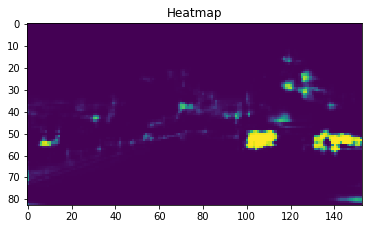

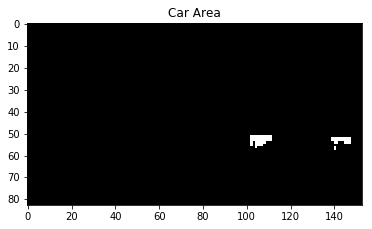

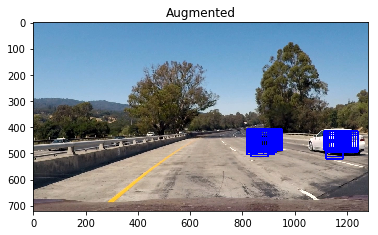

In [10]:
%matplotlib inline
import matplotlib.pylab as plt

def locate():
    data = cv2.cvtColor(cv2.imread("test1.jpg"), cv2.COLOR_BGR2RGB)
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

### What else is there to do

- Lower false positives further. As you can see from the heatmap parts of the tree are a bit dangerous you could consider grabbing a few patches there saving them and adding them to the non-vehicle data

- If you try to run this model on an car image that is way larger than 64x64 pixels you will get funny results. Therefore you will need scaling or region proposals to really catch all possible. But the good news is that a scaling factor of 2 is usually okay (as you can see the cars in the demo image are also to big but detected just fine.

- Optimize for speed by only using sensible image areas sizes.

- Make one box per car. This is called non maximum suppression. Some DL architectures do this out of the box (SSD, YOLO in this simple model you have to do it yourself in code)

### More than two classes

For more than two classes you need the softmax classifier the way it is currently implemented in keras only works in flat arrays. However there is a github project with uses Alexnet, Resnet etc to generate heatmaps in the same style and they also implemented a "Softmax4D" layer. You can check it here https://github.com/heuritech/convnets-keras (very interesting read). Using this our model becomes (something like this). 

Since these customlayers are not maintained by myself I will show a direct tensorflow version below.

In [ ]:
# You need to adapt the Y vector to be [0,1] and [1,0] instead of -1 or -1 for this to work
from customlayers import Softmax4D

def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2,1,1,name="dense2"))
    model.add(Softmax4D(axis=3,name="softmax"))
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

# Now for the tensorflow version:

fortunately tf is nowadays much more accessible than when I wrote this notebook, for the more than two classes version non tensorflow is now a reasonable option:

In [ ]:
import tensorflow as tf
import numpy as np
import glob 
import cv2
import numpy as np

cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])
Y = np.concatenate([np.array([[1,0]]*len(cars)), 
                    np.array([[0,1]]*len(non_cars))]) #note that this needs to be different now

# Read X Vector
X = []
for name in cars:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
for name in non_cars:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
X = np.array(X)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)


def model(data, train):
    norm = data/127.5 - 1
    c1 = tf.layers.conv2d(norm, 16, 3, strides=(1, 1), padding='SAME',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    c2 = tf.layers.conv2d(c1, 16, 3, strides=(1, 1), padding='SAME',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    p = tf.layers.max_pooling2d(c2, 8, strides=(8,8), padding='SAME')
    
    drop1 = tf.layers.dropout(p,rate=0.25,training=train)
    
    c3 = tf.layers.conv2d(drop1, 128, 8, strides=(1, 1), padding='VALID',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    
    drop2 = tf.layers.dropout(c3,rate=0.50,training=train)
    c4 = tf.layers.conv2d(drop2, 2, 1, strides=(1, 1), padding='VALID',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
    sm = tf.nn.softmax(c4, name="output")

    return c4,sm
    
def loss(data, correct_label):    
    logits = tf.reshape(data,(-1,2),name='logits')
    labels = tf.reshape(correct_label,(-1,2),name='lables')
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return loss,train_op,tf_accuracy




batches = (int(np.ceil(X_train.shape[0]/64.)))


with tf.Session() as sess:
    
    tf_data = tf.placeholder(tf.float32, shape=(None, None, None, 3), name="image_input")
    tf_labels = tf.placeholder(tf.float32, shape=(None),name="labels_input")
    tf_train = tf.placeholder(tf.bool,name="train_input")
    
    modelout,sm = model(tf_data, tf_train)
    l,train_op, tf_accuracy = loss(modelout, tf_labels)

    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(20):
        for batch_i in range(batches):
            train_loss, _, accuracy = sess.run([l, train_op, tf_accuracy],
                        feed_dict={tf_data: X_train[batch_i*64:batch_i*64+64], 
                                   tf_labels: Y_train[batch_i*64:batch_i*64+64], 
                                   tf_train: True})
            
        # Display the loss after the epoch
       
        print('Epoch {:>3} Batch {:>2}   Training loss = {:.3f} Acc:{:.3f}'.format(
            epoch_i+1, batch_i+1, train_loss, accuracy))
        
        train_loss, accuracy = sess.run([l, tf_accuracy],feed_dict={tf_data: X_test, tf_labels: Y_test, 
                                   tf_train: False})
        print('Test: Epoch {:>3} Batch {:>2}   Training loss = {:.3f} Acc:{:.3f}'.format(
            epoch_i+1, batch_i+1, train_loss, accuracy))
        
        
    
    saver = tf.train.Saver()
    saver.save(sess, "car-detector.tf",global_step=1000)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples
Epoch   1 Batch 250   Training loss = 0.505 Acc:0.812
Test: Epoch   1 Batch 250   Training loss = 0.427 Acc:0.845
Epoch   2 Batch 250   Training loss = 0.472 Acc:0.833
Test: Epoch   2 Batch 250   Training loss = 0.392 Acc:0.831
Epoch   3 Batch 250   Training loss = 0.411 Acc:0.854
Test: Epoch   3 Batch 250   Training loss = 0.272 Acc:0.893
Epoch   4 Batch 250   Training loss = 0.318 Acc:0.875
Test: Epoch   4 Batch 250   Training loss = 0.290 Acc:0.877
Epoch   5 Batch 250   Training loss = 0.279 Acc:0.896
Test: Epoch   5 Batch 250   Training loss = 0.149 Acc:0.945
Epoch   6 Batch 250   Training loss = 0.144 Acc:0.958
Test: Epoch   6 Batch 250   Training loss = 0.088 Acc:0.971
Epoch   7 Batch 250   Training loss = 0.169 Acc:0.896
Test: Epoch   7 Batch 250   Training loss = 0.080 Acc:0.972
Epoch   8 Batch 250   Training loss = 0.115 Acc:0.979
Test: Epoch   8 Batch 250   Training loss = 0.071 Acc:0.974
Epoch   9 Batch 

Populating the interactive namespace from numpy and matplotlib
INFO:tensorflow:Restoring parameters from ./car-detector.tf-1000


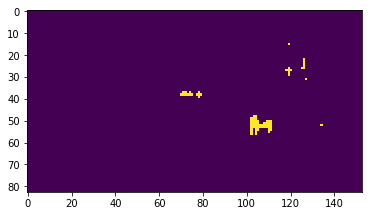

Car: 79
NonCar: 11883


In [17]:
import tensorflow as tf
import cv2
%pylab inline



with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('car-detector.tf-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    
    

    tf_data = graph.get_tensor_by_name("image_input:0")
    tf_train = graph.get_tensor_by_name("train_input:0")
    tf_label = graph.get_tensor_by_name("labels_input:0")    
    sm = graph.get_tensor_by_name("output:0")


    testdata = (cv2.cvtColor(cv2.imread("test1.jpg"), cv2.COLOR_BGR2RGB))
    #print(testdata.shape)
    
    img = sess.run([sm], feed_dict={tf_data: testdata.reshape([1, 720, 1280,3]), tf_train: False})
    
    threshold = 0.95
    
    
    img = np.array(img)
    imshow(img[0,0,:,:,0])
    show()
    print("Car:",np.sum(img[0,0,:,:,0]>threshold))
    print("NonCar:",np.sum(img[0,0,:,:,1]>threshold))
